<a href="https://colab.research.google.com/github/numbstudent/Confused-Student-EEG-Brainwave-Data-Classification-using-XGBoost/blob/main/Confused-Student-EEG-Brainwave-Data-Classification-using-XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**About dataset**

The dataset utilized for analysis and classification comes from Kaggle and is titled "Confused Student EEG Brainwave Data." The specific file used for this purpose is EEG_data.csv. To see description about the dataset please follow this link https://www.kaggle.com/datasets/wanghaohan/confused-eeg .

# Data Exploration

## Import the required dataset


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/EEG_data.csv', encoding='utf-8')
df

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12806,9.0,9.0,64.0,38.0,-39.0,127574.0,9951.0,709.0,21732.0,3872.0,39728.0,2598.0,960.0,1.0,0.0
12807,9.0,9.0,61.0,35.0,-275.0,323061.0,797464.0,153171.0,145805.0,39829.0,571280.0,36574.0,10010.0,1.0,0.0
12808,9.0,9.0,60.0,29.0,-426.0,680989.0,154296.0,40068.0,39122.0,10966.0,26975.0,20427.0,2024.0,1.0,0.0
12809,9.0,9.0,60.0,29.0,-84.0,366269.0,27346.0,11444.0,9932.0,1939.0,3283.0,12323.0,1764.0,1.0,0.0


## Manipulate the dataset
Each trial is given timepoints, since timepoint is not available from the imported data.

In [4]:
df = df.rename(columns={"user-definedlabeln": "userlabel"})


In [5]:
df_new = df.reset_index().drop(df.index)

for i in range(0,10):
  for j in range(0,10):
    query = "SubjectID == "+str(i)+" & VideoID == "+str(j)
    df_temp = df.query(query)
    df_temp = df_temp.reset_index(drop=True)
    df_temp = df_temp.reset_index()
    # print(df_temp)
    df_new = pd.concat([df_new, df_temp])

df_new = df_new.rename(columns={"index": "timepoint"})
df_new = df_new.reset_index(drop=True)
df_new.head()

,timepoint,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,userlabel
0,0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


## Observe characteristics (confused / not confused) by group of frequencies

### Find out correlations between each feature

To identify strong candidates for features, we will apply a correlation matrix to the dataset.

Based on the plot below, it appears that the relationship between each feature is weak. However, it is worth noting that VideoID exhibits a relatively strong correlation with the label. Nevertheless, since VideoID is not intended to be treated as a feature, we will omit this observation. Furthermore, we observe that the correlation between the label and other features is weak.




<Axes: >

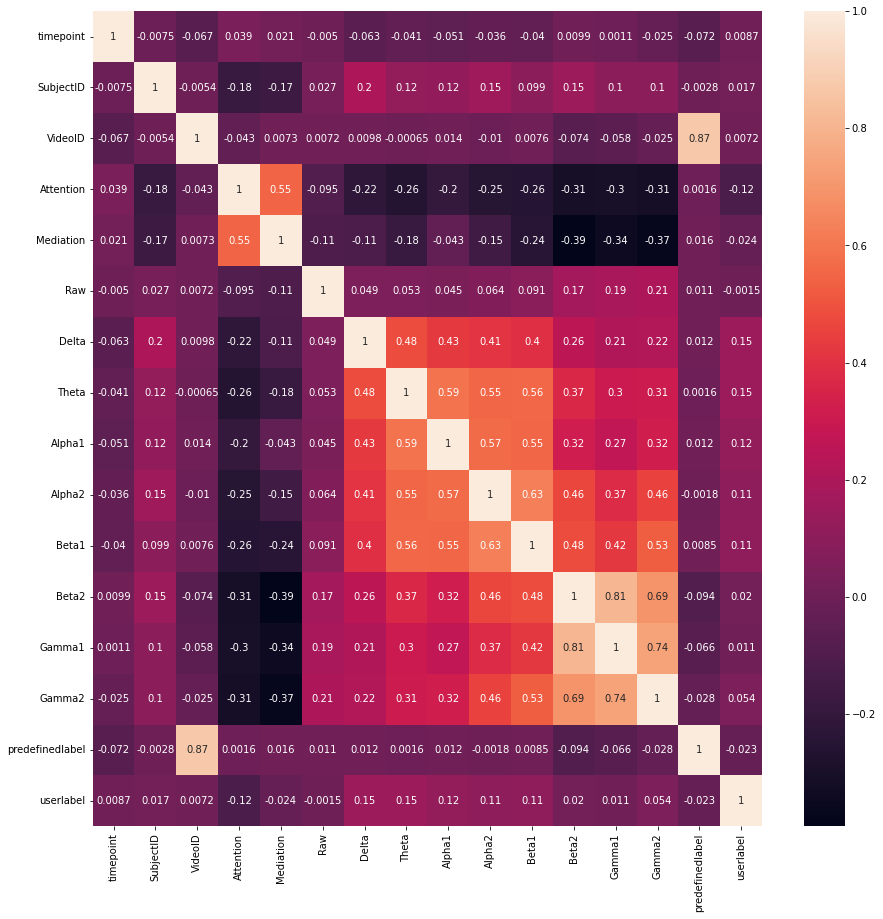

In [6]:
plt.figure(figsize = (15,15))
cor_matrix = df_new.corr()
sns.heatmap(cor_matrix,annot=True)

### Compare the labels by averaging the signals grouped according to their respective labels.

In the next step, we aim to compare the timepoints of confused versus not confused signals. To achieve this, we will categorize the signals into three categories based on the method of labeling: labeled by the author, labeled by the subjects, and labeled by both the author and the subjects. Once the signals are categorized according to their labels, we will compute the average for each timepoint.

In [7]:
def draw_multiple_figures(df_confused,df_understand):
  sns.set(rc={'figure.figsize':(30,8.27)})

  fig, axs = plt.subplots(5, 2)

  sns.lineplot(data=df_confused, x="timepoint", y="Attention",errorbar=None, ax=axs[0,0])
  sns.lineplot(data=df_understand, x="timepoint", y="Attention",errorbar=None, ax=axs[0,0])

  sns.lineplot(data=df_confused, x="timepoint", y="Mediation",errorbar=None, ax=axs[0,1])
  sns.lineplot(data=df_understand, x="timepoint", y="Mediation",errorbar=None, ax=axs[0,1])

  sns.lineplot(data=df_confused, x="timepoint", y="Alpha1",errorbar=None, ax=axs[1,0])
  sns.lineplot(data=df_understand, x="timepoint", y="Alpha1",errorbar=None, ax=axs[1,0])

  sns.lineplot(data=df_confused, x="timepoint", y="Alpha2",errorbar=None, ax=axs[1,1])
  sns.lineplot(data=df_understand, x="timepoint", y="Alpha2",errorbar=None, ax=axs[1,1])

  sns.lineplot(data=df_confused, x="timepoint", y="Beta1",errorbar=None, ax=axs[2,0])
  sns.lineplot(data=df_understand, x="timepoint", y="Beta1",errorbar=None, ax=axs[2,0])

  sns.lineplot(data=df_confused, x="timepoint", y="Beta2",errorbar=None, ax=axs[2,1])
  sns.lineplot(data=df_understand, x="timepoint", y="Beta2",errorbar=None, ax=axs[2,1])

  sns.lineplot(data=df_confused, x="timepoint", y="Gamma1",errorbar=None, ax=axs[3,0])
  sns.lineplot(data=df_understand, x="timepoint", y="Gamma1",errorbar=None, ax=axs[3,0])

  sns.lineplot(data=df_confused, x="timepoint", y="Gamma2",errorbar=None, ax=axs[3,1])
  sns.lineplot(data=df_understand, x="timepoint", y="Gamma2",errorbar=None, ax=axs[3,1])

  sns.lineplot(data=df_confused, x="timepoint", y="Delta",errorbar=None, ax=axs[4,0])
  sns.lineplot(data=df_understand, x="timepoint", y="Delta",errorbar=None, ax=axs[4,0])

  sns.lineplot(data=df_confused, x="timepoint", y="Theta",errorbar=None, ax=axs[4,1])
  sns.lineplot(data=df_understand, x="timepoint", y="Theta",errorbar=None, ax=axs[4,1])

  fig.legend(labels=['confused','not confused'], loc="lower center", ncol=2)
  fig.suptitle("Confused vs Not Confused by Groups of Frequency")

  plt.show()

### Comparison between Confused vs Not Confused in dataset labeled by the author.

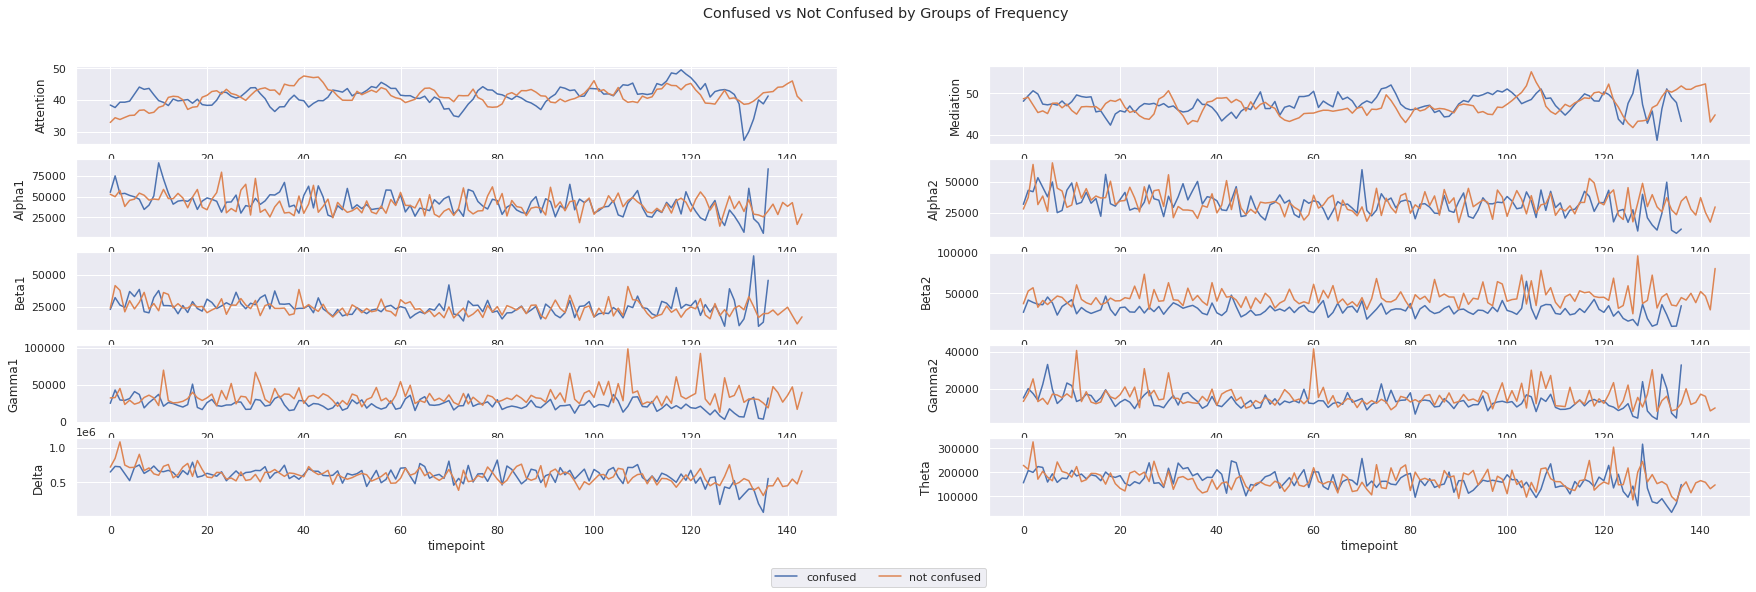

In [8]:
query = "predefinedlabel == 1"
df_confused = df_new.query(query)

query = "predefinedlabel == 0"
df_understand = df_new.query(query)

draw_multiple_figures(df_confused,df_understand)

### Comparison between Confused vs Not Confused in dataset labeled by subjects.

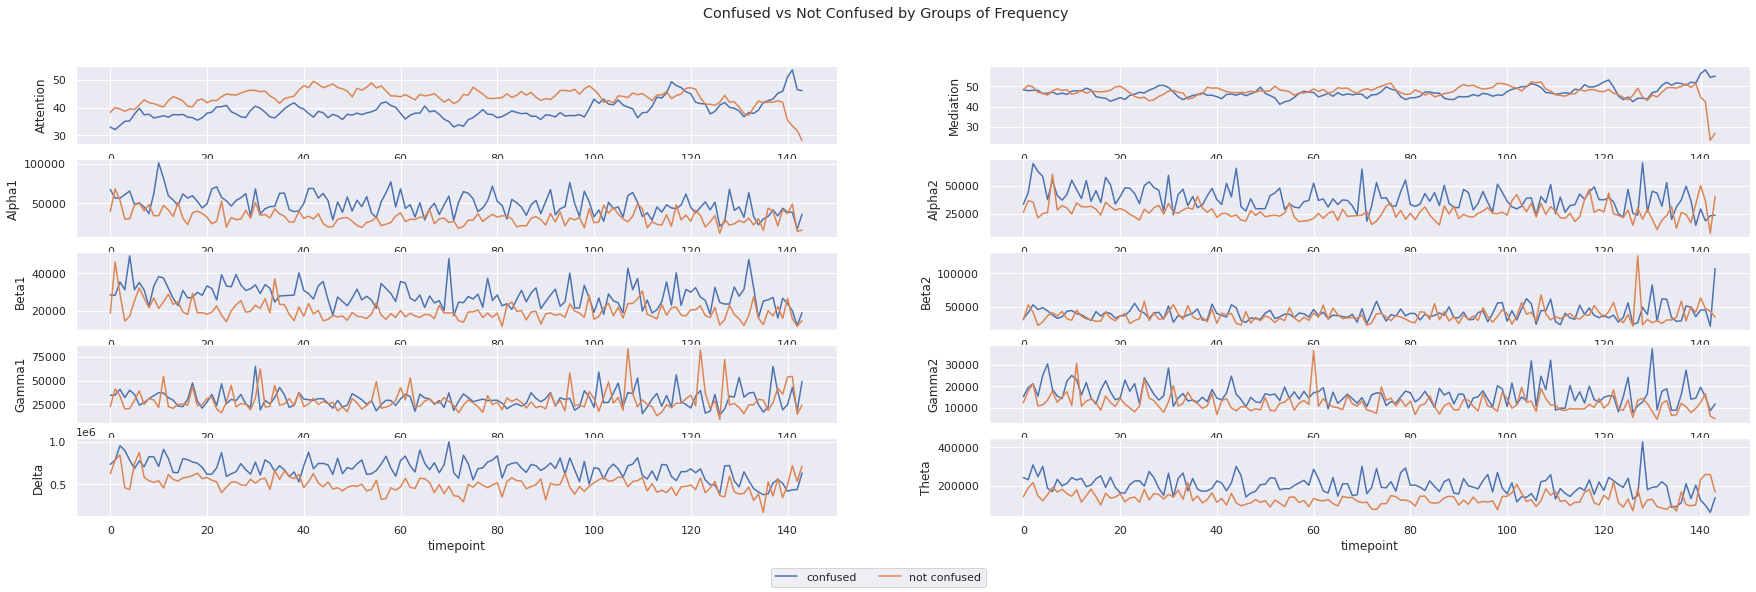

In [9]:
query = "userlabel == 1"
df_confused = df_new.query(query)

query = "userlabel == 0"
df_understand = df_new.query(query)

draw_multiple_figures(df_confused,df_understand)

### Comparison between Confused vs Not Confused in dataset same-labeled by the author and subjects.

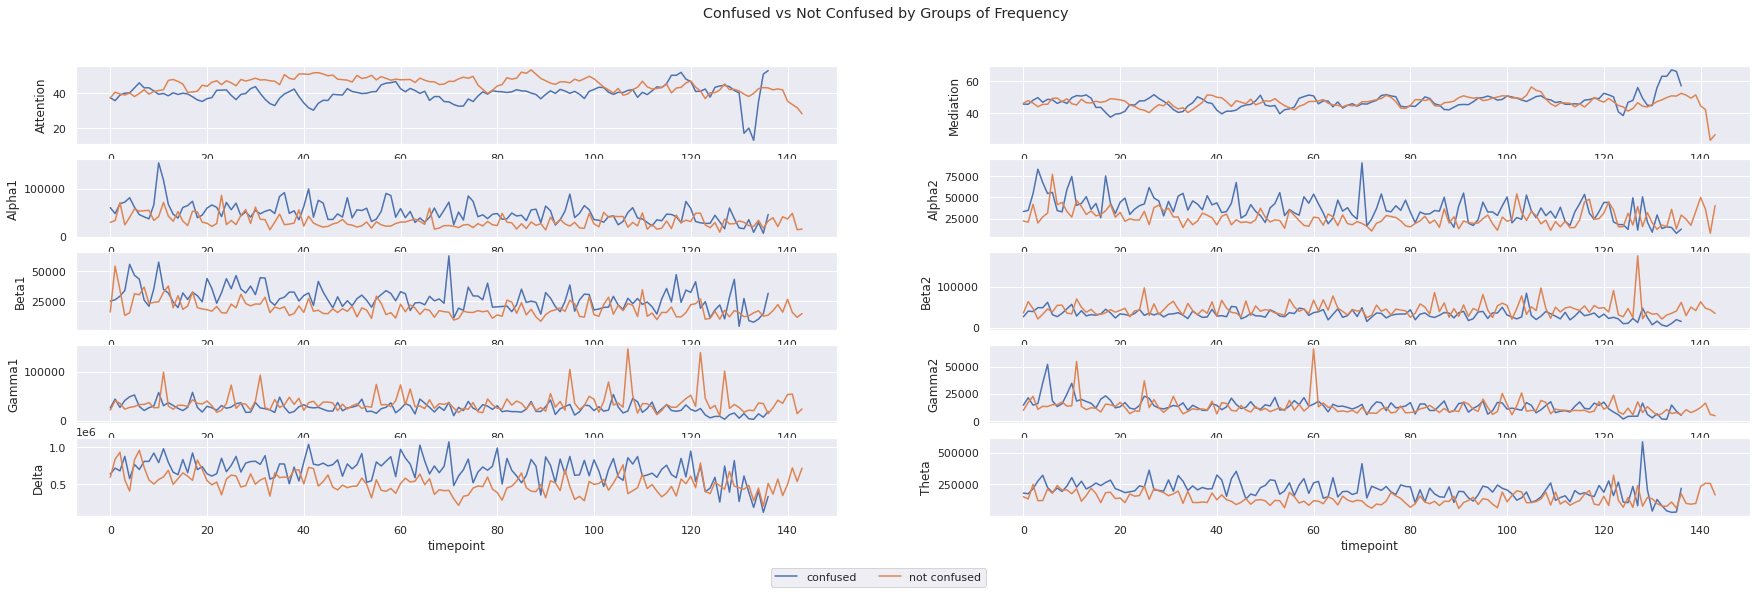

In [10]:
query = "predefinedlabel == 1 & userlabel == 1"
df_confused = df_new.query(query)

query = "predefinedlabel == 0 & userlabel == 0"
df_understand = df_new.query(query)

draw_multiple_figures(df_confused,df_understand)

# Data Training and Classification

## Training dataset preparation, using only data same-labeled by the author and subjects

In [11]:
df_true = df_new.query("(predefinedlabel == 0 & userlabel == 0) | (predefinedlabel == 1 & userlabel == 1)")
X = df_true[['Delta','Theta','Alpha1','Alpha2','Beta1','Beta2','Gamma1','Gamma2']]
	
print(X.isna().sum())
print(X.shape)
Y = df_true.predefinedlabel
print(Y.shape)

Delta     0
Theta     0
Alpha1    0
Alpha2    0
Beta1     0
Beta2     0
Gamma1    0
Gamma2    0
dtype: int64
(6253, 8)
(6253,)


In [12]:
print(df_true[df_true['predefinedlabel'] == 1].shape)
print(df_true[df_true['predefinedlabel'] == 0].shape)
print(df_true.shape)

(3079, 16)
(3174, 16)
(6253, 16)


## Classification using XGBoost

In [13]:
import xgboost
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,
                                random_state=42)

model = xgboost.XGBClassifier(base_score=0.5, learning_rate=0.1,max_depth=6,
        objective='binary:logistic')
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [14]:
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]

In [15]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 67.07%


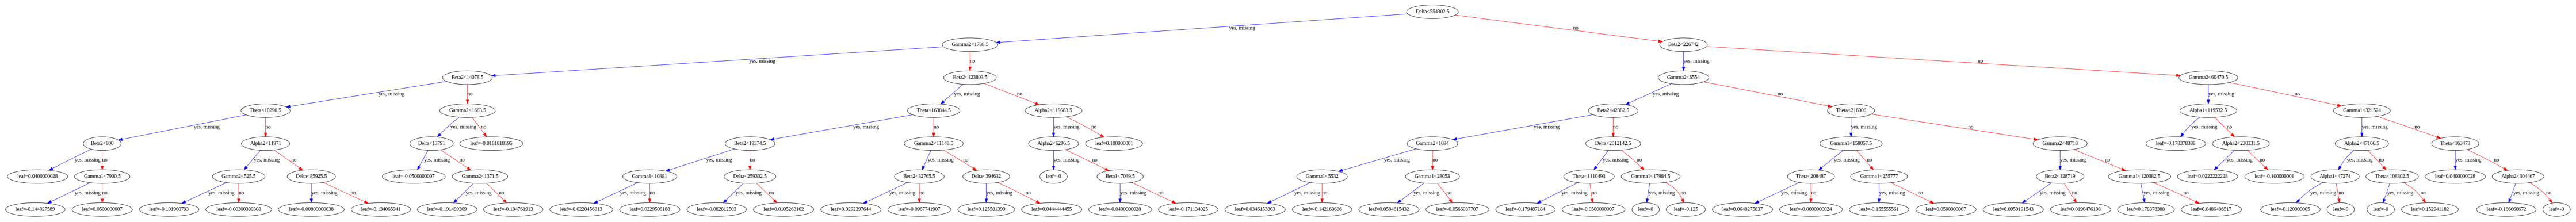

In [16]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 80,50

plot_tree(model)
plt.show()

# Next to do

In [17]:
def moving_average(x, w = 10):
    return np.convolve(x, np.ones(w), 'valid') / w

In [18]:
df_ma = pd.DataFrame(columns = ['Attention','Mediation','Delta','Theta','Alpha1','Alpha2','Beta1','Beta2','Gamma1','Gamma2','Label'])

for i in range(int(df_true.SubjectID.min()), int(df_true.SubjectID.max()+1)):
  for j in range(int(df_true.VideoID.min()), int(df_true.VideoID.max()+1)):
    for k in range(0,2):
      if len(df_true[(df_true.predefinedlabel == k) & (df_true.SubjectID == i) & (df_true.VideoID == j)].Attention) > 0 :
        attention = moving_average(df_true[(df_true.predefinedlabel == k) & (df_true.SubjectID == i) & (df_true.VideoID == j)].Attention)
        mediation = moving_average(df_true[(df_true.predefinedlabel == k) & (df_true.SubjectID == i) & (df_true.VideoID == j)].Mediation)
        delta = moving_average(df_true[(df_true.predefinedlabel == k) & (df_true.SubjectID == i) & (df_true.VideoID == j)].Delta)
        theta = moving_average(df_true[(df_true.predefinedlabel == k) & (df_true.SubjectID == i) & (df_true.VideoID == j)].Theta)
        alpha1 = moving_average(df_true[(df_true.predefinedlabel == k) & (df_true.SubjectID == i) & (df_true.VideoID == j)].Alpha1)
        alpha2 = moving_average(df_true[(df_true.predefinedlabel == k) & (df_true.SubjectID == i) & (df_true.VideoID == j)].Alpha2)
        beta1 = moving_average(df_true[(df_true.predefinedlabel == k) & (df_true.SubjectID == i) & (df_true.VideoID == j)].Beta1)
        beta2 = moving_average(df_true[(df_true.predefinedlabel == k) & (df_true.SubjectID == i) & (df_true.VideoID == j)].Beta2)
        gamma1 = moving_average(df_true[(df_true.predefinedlabel == k) & (df_true.SubjectID == i) & (df_true.VideoID == j)].Gamma1)
        gamma2 = moving_average(df_true[(df_true.predefinedlabel == k) & (df_true.SubjectID == i) & (df_true.VideoID == j)].Gamma2)
        if k == 1:
          label = np.ones(len(attention))
        else:
          label = np.zeros(len(attention))
        timepoint = np.arange(len(attention))
        array = np.stack((timepoint, attention, mediation, delta, theta, alpha1, alpha2, beta1, beta2, gamma1, gamma2, label))
        array = np.transpose(array)
        df_temp = pd.DataFrame(array, columns = ['timepoint','Attention','Mediation','Delta','Theta','Alpha1','Alpha2','Beta1','Beta2','Gamma1','Gamma2','Label'])
        df_ma = pd.concat([df_ma, df_temp])

print(df_ma)

     Attention  Mediation     Delta     Theta   Alpha1   Alpha2    Beta1  \
0         45.1       57.0  730906.7  153457.8  59794.7  38078.0  22875.2   
1         44.3       56.5  776426.9  163016.2  56745.4  36063.0  21966.0   
2         44.7       57.8  835799.5  174393.3  64106.5  37462.4  26284.0   
3         44.7       56.4  776500.2  140230.7  44222.4  31877.3  23381.7   
4         44.8       53.7  649042.7  135723.2  38322.3  34043.7  24403.4   
..         ...        ...       ...       ...      ...      ...      ...   
110       59.7       52.9  696266.1  134271.3  24167.2  19734.7  20748.9   
111       59.4       52.6  728067.2  147023.7  47176.4  24000.7  27738.6   
112       56.8       51.9  647406.8  141006.7  45746.4  23283.2  23621.7   
113       55.9       51.9  790189.1  159394.5  47639.8  23119.3  25662.5   
114       54.1       52.1  789421.8  161619.5  47606.7  23170.1  25701.0   

       Beta2   Gamma1   Gamma2  Label  timepoint  
0    54852.8  39680.7  25812.9    0.

In [19]:
X = df_ma[['Delta','Theta','Alpha1','Alpha2','Beta1','Beta2','Gamma1','Gamma2']]
#X = df_ma[['Attention','Mediation','Delta','Theta','Alpha1','Alpha2','Beta1','Beta2','Gamma1','Gamma2']]

	
print(X.isna().sum())
print(X.shape)
Y = df_ma.Label
print(Y.shape)

Delta     0
Theta     0
Alpha1    0
Alpha2    0
Beta1     0
Beta2     0
Gamma1    0
Gamma2    0
dtype: int64
(5812, 8)
(5812,)


In [20]:
import xgboost
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,
                                random_state=42)

model = xgboost.XGBClassifier(base_score=0.5, learning_rate=0.1,max_depth=6,
        objective='binary:logistic')
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [21]:
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]

In [22]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.20%


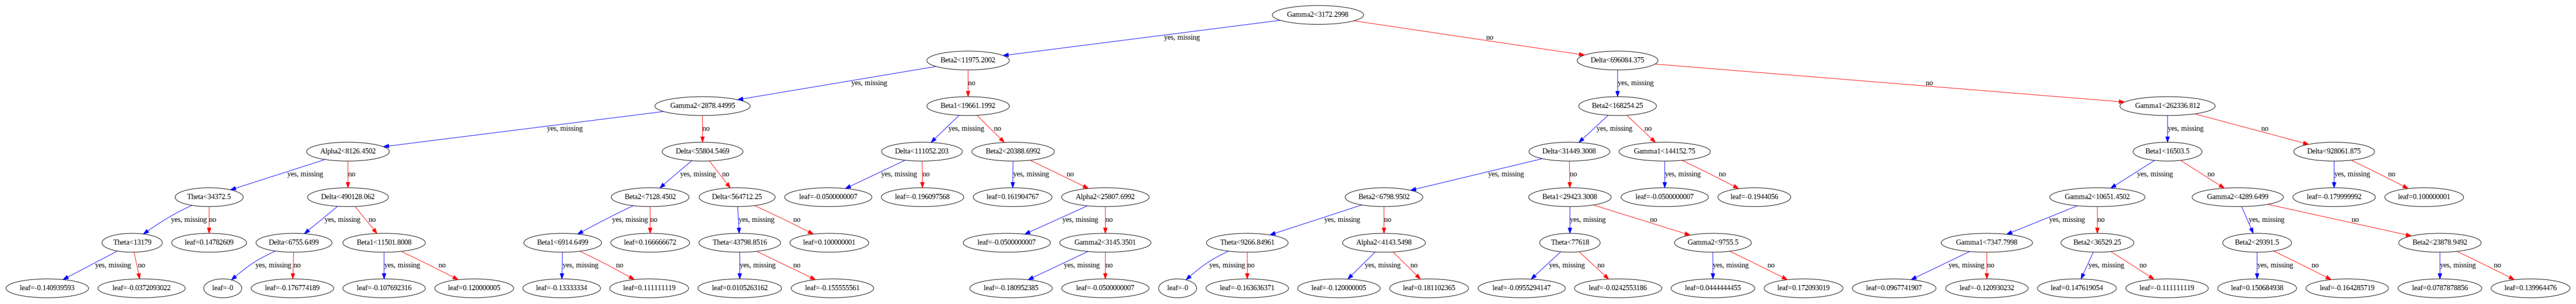

In [23]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 80,50

plot_tree(model)
plt.show()

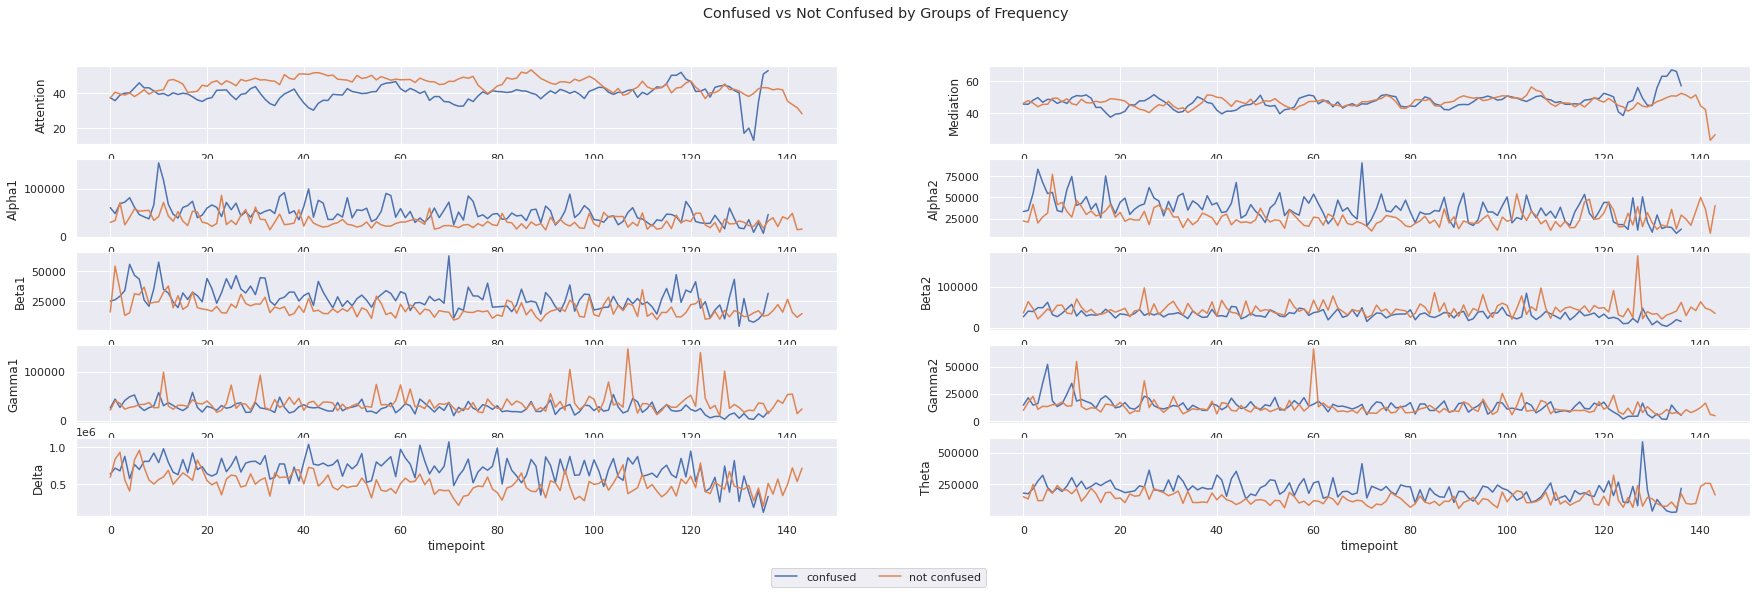

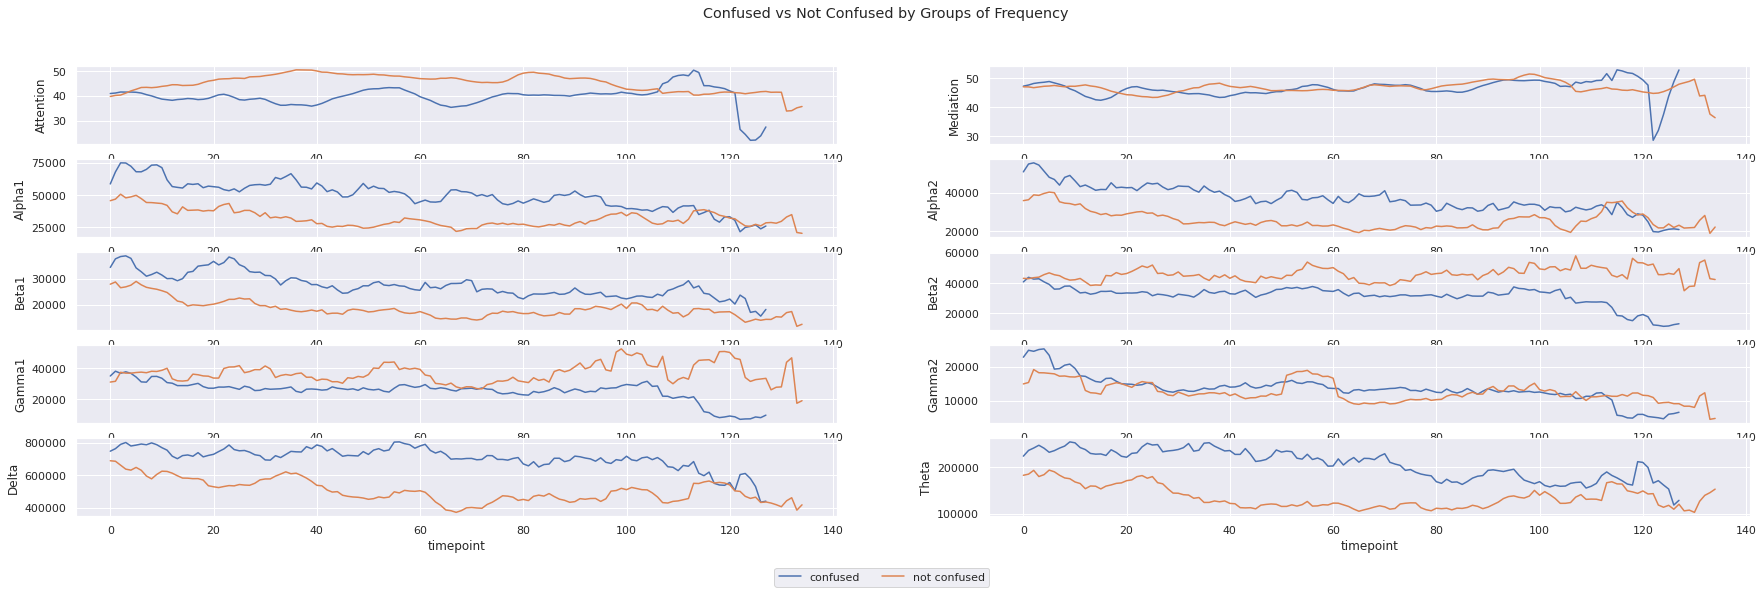

In [24]:
query = "predefinedlabel == 1 & userlabel == 1"
df_confused = df_new.query(query)

query = "predefinedlabel == 0 & userlabel == 0"
df_understand = df_new.query(query)

draw_multiple_figures(df_confused,df_understand)

query = "Label == 1"
df_confused = df_ma.query(query)

query = "Label == 0"
df_understand = df_ma.query(query)

draw_multiple_figures(df_confused,df_understand)

<Axes: >

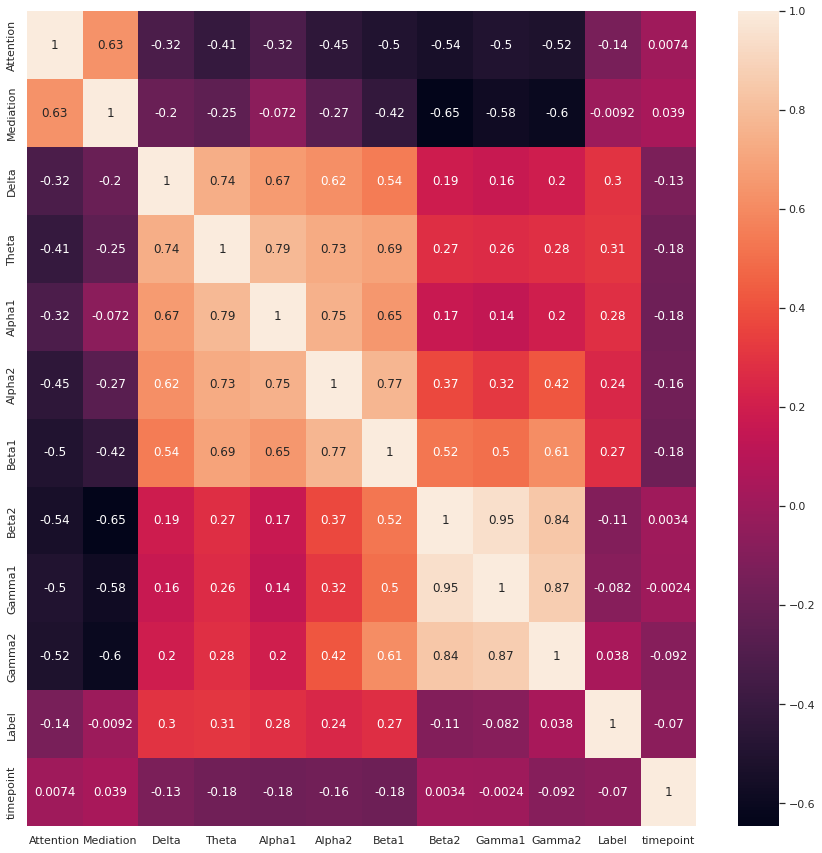

In [25]:
plt.figure(figsize = (15,15))
cor_matrix = df_ma.corr()
sns.heatmap(cor_matrix,annot=True)